In [1]:
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from collections import Counter
from scipy.signal import find_peaks
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import matplotlib.colors as colors
from sklearn.manifold import Isomap

In [2]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

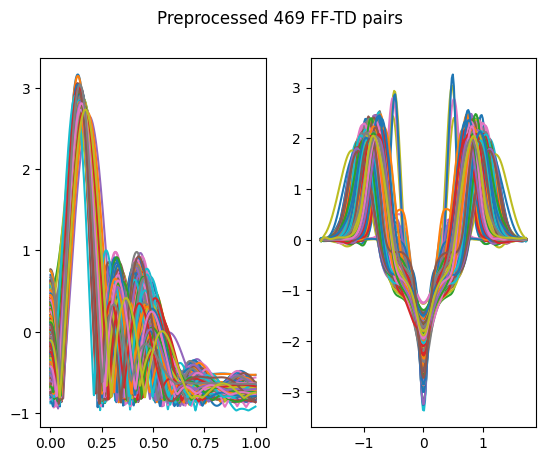

(375, 4)
(375, 400)
(94, 4)
(94, 400)


In [3]:
def get_peak_data(FF_df,TD_y_df):
    FF_min_and_max_points = []
    FF_min_and_max_points_amounts = []
    
    TD_min_and_max_points = []
    TD_min_and_max_points_amounts = []
    
    for column in FF_df.columns:
        max_peaks_FF, _ = find_peaks(FF_df[column])
        min_peaks_FF, _ = find_peaks(-FF_df[column])
        
        FF_peak_indexes = np.hstack((max_peaks_FF, min_peaks_FF))
        FF_peak_indexes.sort()
        FF_peak_value = FF_df[column][FF_peak_indexes]
        
        FF_min_and_max_points.append(list(FF_peak_value))
        FF_min_and_max_points_amounts.append([len(min_peaks_FF), len(max_peaks_FF)])
        
        max_peaks_TD, _ = find_peaks(TD_y_df[column])
        min_peaks_TD, _ = find_peaks(-TD_y_df[column])
        
        TD_peak_indexes = np.hstack((max_peaks_TD, min_peaks_TD))
        TD_peak_indexes.sort()
        TD_peak_value = TD_y_df[column][TD_peak_indexes]
         
        TD_min_and_max_points.append(list(TD_peak_value))
        TD_min_and_max_points_amounts.append([len(min_peaks_TD), len(max_peaks_TD)])
        
    FF_peak_df = pd.DataFrame(FF_min_and_max_points)
    FF_peak_df = FF_peak_df.transpose()
    FF_peak_df.columns = FF_df.columns
    
    TD_peak_df = pd.DataFrame(TD_min_and_max_points)
    TD_peak_df = TD_peak_df.transpose()
    TD_peak_df.columns = TD_y_df.columns
    
    return FF_peak_df, FF_min_and_max_points_amounts, TD_peak_df, TD_min_and_max_points_amounts 

def get_common_peak_samples(FF_df,TD_x_df,TD_y_df,FF_peak_df,TD_peak_df,s_p):
    FF_n_nans = FF_peak_df.isna().sum(axis=0)
    FF_peak_freq = FF_peak_df.isna().sum(axis=0).value_counts().values
    FF_peak_values = FF_peak_df.isna().sum(axis=0).value_counts().index
    
    sample_amount = round(FF_peak_df.shape[1]*s_p,1)
    found_amount = 0
    sample_nans = []
    i = 0
    for nans in FF_peak_values:
        if found_amount < sample_amount:
            sample_nans.append(nans)
            found_amount = found_amount + FF_peak_freq[i]
        i = i + 1
        
    Common_peak_FF_columns = set()
    filtered_peaks = [] 
    for nans in sample_nans:
        column_names = FF_n_nans[FF_n_nans == nans].index
        
        for column in FF_peak_df[column_names].columns:
            Common_peak_FF_columns.add(column)
            filtered_peaks.append(FF_peak_df[column])
     
    Common_peak_FF_columns = list(Common_peak_FF_columns)
    peak_filtered_FF_df = pd.DataFrame(filtered_peaks)
    peak_filtered_FF_df = peak_filtered_FF_df.transpose()
    peak_filtered_FF_df.columns = Common_peak_FF_columns
    
    Removed_cases = random.sample(Common_peak_FF_columns,int(found_amount-sample_amount))
    Samples = []
    for column in Common_peak_FF_columns:
        if column in Removed_cases:
            continue
        Samples.append(column)
    Samples.sort()
    
    Common_peak_FF_df = FF_df[Samples]
    Common_peak_TD_x_df = TD_x_df[Samples]
    Common_peak_TD_y_df = TD_y_df[Samples]
    Common_peak_points_FF_df = peak_filtered_FF_df[Samples]
    
    return Common_peak_FF_df, Common_peak_TD_x_df, Common_peak_TD_y_df, Common_peak_points_FF_df, Samples.copy()

def remove_outliers(Common_peak_FF_df,Common_peak_TD_x_df, Common_peak_TD_y_df,Common_peak_points_FF_df, min_case_amount):
    FF_peak_n_nans = Common_peak_points_FF_df.isna().sum(axis=0)
    FF_peak_freq = Common_peak_points_FF_df.isna().sum(axis=0).value_counts().values
    FF_peak_values = Common_peak_points_FF_df.isna().sum(axis=0).value_counts().index
    
    removed_outliers = []
    
    for nans in FF_peak_values:
        column_names = FF_peak_n_nans[FF_peak_n_nans == nans].index
        
        selected_peak_FF_df = Common_peak_FF_df[column_names]
        selected_TD_x_df = Common_peak_TD_x_df[column_names]
        selected_TD_y_df = Common_peak_TD_y_df[column_names]
        
        flat_outliers = []
        
        for column in selected_TD_y_df.columns:
            if selected_TD_y_df[column][99] > -1:
                flat_outliers.append(column)
                removed_outliers.append(column)
                
        if len(flat_outliers) > 0:
            selected_peak_FF_df = selected_peak_FF_df.drop(flat_outliers, axis=1)
            selected_TD_x_df = selected_TD_x_df.drop(flat_outliers, axis=1)
            selected_TD_y_df = selected_TD_y_df.drop(flat_outliers, axis=1)
        
        #for column in selected_peak_FF_df.columns:
        #    plt.subplot(1, 2, 1)
        #    plt.plot([round(i * 0.001,4) for i in range(0, 1000,1)], selected_peak_FF_df[column])
        #    plt.subplot(1, 2, 2)
        #    plt.plot(selected_TD_x_df[column],selected_TD_y_df[column])
        
        #plt.show()
        
        TD_min_and_max_points = []
        for column in selected_TD_y_df.columns:
            max_peaks_TD, _ = find_peaks(selected_TD_y_df[column])
            min_peaks_TD, _ = find_peaks(-selected_TD_y_df[column])

            TD_peak_indexes = np.hstack((max_peaks_TD, min_peaks_TD))
            TD_peak_indexes.sort()
            TD_peak_value = selected_TD_y_df[column][TD_peak_indexes]
            
            TD_min_and_max_points.append(list(TD_peak_value))
            
        TD_peak_df = pd.DataFrame(TD_min_and_max_points)
        TD_peak_df = TD_peak_df.transpose()
        TD_peak_df.columns = selected_TD_y_df.columns 
        
        TD_peak_n_nans = TD_peak_df.isna().sum(axis=0)
        TD_peak_freq = TD_peak_df.isna().sum(axis=0).value_counts().values
        TD_peak_values = TD_peak_df.isna().sum(axis=0).value_counts().index
        j = 0
        for TD_nans in TD_peak_values:
            TD_column_names = TD_peak_n_nans[TD_peak_n_nans == TD_nans].index
            if TD_peak_freq[j] < min_case_amount:
                removed_outliers.extend(list(TD_column_names))
                continue
            
            FF_first_100_cases = []
            h = 0
            for column in TD_column_names:
                if selected_peak_FF_df[column][0] >= 100:
                    FF_first_100_cases.append(column)
                    removed_outliers.append(column)
                
            #if len(FF_first_100_cases) > 0:
            #    selected_peak_FF_df = selected_peak_FF_df.drop(FF_first_100_cases, axis=1)
            #    selected_TD_x_df = selected_TD_x_df.drop(FF_first_100_cases, axis=1)
            #    selected_TD_y_df = selected_TD_y_df.drop(FF_first_100_cases, axis=1)
                
            #for column in TD_column_names:
            #    if column in FF_first_100_cases:
            #        continue
            #    plt.subplot(1, 2, 1)
            #    plt.plot([round(i * 0.001,4) for i in range(0, 1000,1)], selected_peak_FF_df[column])
            #    plt.subplot(1, 2, 2)
            #    plt.plot(selected_TD_x_df[column],selected_TD_y_df[column])
            
            #plt.show()
            j = j + 1
    
    return removed_outliers
                
def FF_to_TD_preprocessing(FF_df, TD_x_df, TD_y_df, s_p):
    random.seed(42)
    FF_peak_df, FF_point_amounts, TD_peak_df, TD_points_amounts = get_peak_data(FF_df,TD_y_df)
    Common_peak_FF_df, Common_peak_TD_x_df, Common_peak_TD_y_df, Common_peak_points_FF_df, Samples = get_common_peak_samples(FF_df, TD_x_df, TD_y_df,FF_peak_df,TD_peak_df,s_p)
    
    zeroing = round((Common_peak_TD_y_df.iloc[0]+Common_peak_TD_y_df.iloc[-1])/2,3)
    Common_peak_TD_y_df = Common_peak_TD_y_df.subtract(zeroing)
    
    removed_outliers = remove_outliers(Common_peak_FF_df,Common_peak_TD_x_df, Common_peak_TD_y_df,Common_peak_points_FF_df, 2)
    
    Common_peak_FF_df = Common_peak_FF_df.drop(removed_outliers, axis=1)
    Common_peak_TD_x_df = Common_peak_TD_x_df.drop(removed_outliers, axis=1)
    Common_peak_TD_y_df = Common_peak_TD_y_df.drop(removed_outliers, axis=1)
    
    FF_scaled_values = []
    for column in Common_peak_FF_df.columns:
        FF_scaled_values.append((Common_peak_FF_df[column] - Common_peak_FF_df[column].mean()) / Common_peak_FF_df[column].std())
    
    FF_scaled_df = pd.DataFrame(FF_scaled_values)
    FF_scaled_df = FF_scaled_df.transpose()
    FF_scaled_df.columns = Common_peak_FF_df.columns
    
    TD_x_scaled_values = []
    for column in Common_peak_TD_x_df.columns:
        TD_x_scaled_values.append((Common_peak_TD_x_df[column] - Common_peak_TD_x_df[column].mean()) / Common_peak_TD_x_df[column].std())
    
    TD_x_scaled_df = pd.DataFrame(TD_x_scaled_values)
    TD_x_scaled_df = TD_x_scaled_df.transpose()
    TD_x_scaled_df.columns = Common_peak_TD_x_df.columns
    
    TD_y_scaled_values = []
    for column in Common_peak_TD_y_df.columns:
        TD_y_scaled_values.append((Common_peak_TD_y_df[column] - Common_peak_TD_y_df[column].mean()) / Common_peak_TD_y_df[column].std())
    
    TD_y_scaled_df = pd.DataFrame(TD_y_scaled_values)
    TD_y_scaled_df = TD_y_scaled_df.transpose()
    TD_y_scaled_df.columns = Common_peak_TD_y_df.columns
    
    zeroing = round((TD_y_scaled_df.iloc[0]+TD_y_scaled_df.iloc[-1])/2,3)
    TD_y_scaled_df = TD_y_scaled_df.subtract(zeroing)
    
    for column in FF_scaled_df.columns:
        plt.subplot(1, 2, 1)
        plt.plot([round(i * 0.001,4) for i in range(0, 1000,1)], FF_scaled_df[column])
        plt.subplot(1, 2, 2)
        plt.plot(TD_x_scaled_df[column],TD_y_scaled_df[column])
        
    plt.suptitle('Preprocessed ' + str(FF_scaled_df.shape[1]) + ' FF-TD pairs')
    plt.show()
    #print(FF_scaled_df.shape)
    pca = PCA(n_components = 2)
    FF_PCA = pca.fit_transform(FF_scaled_df.transpose())
    
    FF_values = []
    g = 0
    for column in FF_scaled_df.columns: 
        FF_values.append([FF_PCA[g][0], FF_PCA[g][1], FF_point_amounts[column][0], FF_point_amounts[column][1]])
        g = g + 1
        
    FF_scaled_PCA = pd.DataFrame(FF_values)
    FF_scaled_PCA = FF_scaled_PCA.transpose()
    FF_scaled_PCA.columns = FF_scaled_df.columns
    
    train = random.sample(list(FF_scaled_df.columns),int(round(FF_scaled_df.shape[1]*0.8,0)))
    test = []
    for number in list(FF_scaled_df.columns):
        if not number in train:
            test.append(number)
            
    TD_scaled_df = pd.concat([TD_x_scaled_df, TD_y_scaled_df], axis=0)
    train_input = FF_scaled_PCA[train].transpose().values.astype(np.float32)
    train_output = TD_scaled_df[train].transpose().values.astype(np.float32)
    test_input = FF_scaled_PCA[test].transpose().values.astype(np.float32)
    test_output = TD_scaled_df[test].transpose().values.astype(np.float32)
            
    print(train_input.shape)
    print(train_output.shape)
    print(test_input.shape)
    print(test_output.shape)
    
    
    #TD_scaled_df = pd.concat([TD_x_scaled_df, TD_y_scaled_df], axis=0)
    #train_input = FF_scaled_df[train].transpose().values.astype(np.float32)
    #train_output = TD_scaled_df[train].transpose().values.astype(np.float32)
    #test_input = FF_scaled_df[test].transpose().values.astype(np.float32)
    #test_output = TD_scaled_df[test].transpose().values.astype(np.float32)
    # PCA, FA, Kernel PCA, t-SNE, MDS, Isomap
    
    #cases = set()
    #for values in FF_point_amounts: 
    #    cases.add((values[0],values[1]))
        
    #cases = list(cases)
    
    #print(cases)
    #[(4, 4), (5, 5), (7, 7), (6, 5), (4, 3), (8, 7), (9, 9), (5, 4), (6, 7), (4, 5), (7, 6), (5, 6), (6, 6), (12, 11)]
    
    #colors = {
    #    (4, 4): 'red',
    #    (5, 5): 'blue',
    #    (7, 7): 'grey', 
    #    (6, 5): 'green', 
    #    (4, 3): 'orange', 
    #    (8, 7): 'violet', 
    #    (9, 9): 'black', 
    #    (5, 4): 'cyan', 
    #    (6, 7): 'indigo', 
    #     (4, 5): 'navy', 
    #     (7, 6): 'yellow', 
    #    (5, 6): 'lime', 
    #    (6, 6): 'crimson', 
    #    (12, 11): 'khaki'
    #}
    
    
    #print(cases)
    
    #cmap = plt.get_cmap('viridis')
    
    # PCA, FA, Kernel PCA, t-SNE, MDS, Isomap
    #print(FF_scaled_df.shape)
    #pca = PCA(n_components = 2)
    #pca.fit(FF_scaled_df.transpose())
    #FF_PCA = pca.transform(FF_scaled_df.transpose())
    
    #k = 0
    #for values in FF_PCA:
        #print(colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])])
    #    color_label = str(FF_point_amounts[k][0]) + '-' + str(FF_point_amounts[k][1])
    #    plt.scatter(values[0],values[1],color=colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])], label = color_label)
    #    k = k + 1
    #plt.legend()
    #plt.title('FF PCA')
    #plt.show()
    
    #kpca = KernelPCA(n_components = 2, kernel = 'sigmoid')
    #FF_KPCA = kpca.fit_transform(FF_scaled_df.transpose())
    
    #k = 0
    #for values in FF_KPCA:
    #    plt.scatter(values[0],values[1],color=colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])])
    #    k = k + 1
    #plt.title('FF KPCA')
    #plt.show()
    
    #tsne = TSNE(n_components=2, verbose=0, n_iter=300)
    #FF_TSNE = tsne.fit_transform(FF_scaled_df.transpose())
    
    #k = 0
    #for values in FF_TSNE:
    #    plt.scatter(values[0],values[1],color=colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])])
    #    k = k + 1
    #plt.title('FF TSNE')
    #plt.show()
    
    #tsne = TSNE(n_components=2, verbose=0, n_iter=300)
    #FF_TSNE = tsne.fit_transform(FF_PCA)
    
    #k = 0
    #for values in FF_TSNE:
    #    plt.scatter(values[0],values[1],color=colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])])
    #    k = k + 1
    #plt.title('FF PCA-TSNE')
    #plt.show()
    
    #mds = MDS(n_components=2, 
    #            max_iter=300, 
    #            random_state=42, 
    #            dissimilarity='euclidean')
    #FF_MDS = mds.fit_transform(FF_scaled_df.transpose())
    
    #k = 0
    #for values in FF_MDS:
    #    plt.scatter(values[0],values[1],color=colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])])
    #    k = k + 1
    #plt.title('FF MDS')
    #plt.show()
    
    #im = Isomap(n_components = 2)
    #FF_IM = im.fit_transform(FF_PCA)
    
    #k = 0
    #for values in FF_MDS:
    #    plt.scatter(values[0],values[1],color=colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])])
    #    k = k + 1
    #plt.title('FF PCA-MDS')
    #plt.show()
    
    #im = Isomap(n_components = 2)
    #FF_IM = im.fit_transform(FF_scaled_df.transpose())
    
    #k = 0
    #for values in FF_IM:
    #    plt.scatter(values[0],values[1],color=colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])])
    #    k = k + 1
    #plt.title('FF Isomap')
    #plt.show()
    
    #im = Isomap(n_components = 2)
    #FF_IM = im.fit_transform(FF_PCA)
    
    #k = 0
    #for values in FF_IM:
    #    plt.scatter(values[0],values[1],color=colors[(FF_point_amounts[k][0],FF_point_amounts[k][1])])
    #    k = k + 1
    #plt.title('FF PCA-Isomap')
    #plt.show()
    
    #FF_cov = np.cov(FF_scaled_df.transpose())
    #eig_values, eig_vectors = np.linalg.eig(FF_cov)
    
    #sorted_index = np.argsort(eig_values)
    
    #sorted_eig_values = eig_values[sorted_index]
    
    #total_variance = np.sum(sorted_eig_values)
    
    #cumulative_variance = np.cumsum(sorted_eig_values) / total_variance
    
    #num_eig_vectors = np.argmax(cumulative_variance >= 0.95) + 1
    
    #selected_eig_vectors = eig_vectors[:, sorted_index[:num_eig_vectors]]
    
    #print(num_eig_vectors)
    
    #total_sum = np.sum(eig_values)
    #sorted_eig_values = np.sort(eig_values)
    #cumulative_sum = np.cumsum(sorted_eig_values)
    #num_eigenvectors = np.argmax(cumulative_sum >= 0.95 * total_sum) + 1
    #print(num_eigenvectors)
    
    #top_eigen_vectors = eig_vectors[:,:num_eigenvectors]
    #print(top_eigen_vectors.shape)
    
    
    #explained_variances = eig_values / np.sum(eig_values)
    #explained_variances_cumulative = np.cumsum(explained_variances)
    #num_eigenvectors = np.argmax(explained_variances_cumulative >= 0.95) + 1
    #print(num_eigenvectors)
    
    
    #explained_variances = eig_values / np.sum(eig)
        
    return train_input, train_output, test_input, test_output

train_input, train_output, test_input, test_output = FF_to_TD_preprocessing(FF_df, TD_x_df, TD_y_df,0.9)

In [4]:
def single_average_loss(actual,prediction):
    length = int(actual.shape[0]/2)
    
    t_x = actual[0:length]
    t_y = actual[length:]
    p_x = prediction[0:length]
    p_y = prediction[length:]
    
    distance_sum = 0
    for i in range(0,length):
        distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)

    return (distance_sum/length)

def metrics(actual,prediction):
    amount = int(actual.shape[0])
    length = int(actual.shape[1]/2)
    
    index = 0
    loss_list = []
    for data in prediction:
        p_x = data[0:length]
        p_y = data[length:]
        t_x = actual[index][0:length]
        t_y = actual[index][length:]
         
        distance_sum = 0
        for i in range(0,length):
            distance_sum = distance_sum + math.sqrt((t_x[i]-p_x[i])**2 + (t_y[i]-p_y[i])**2)
            
        loss_list.append(distance_sum/length)
        index = index + 1
     
    average_loss = sum(loss_list)/amount
    mode_loss = Counter(np.round(loss_list,5)).most_common(10)
    median_loss = st.median(np.round(loss_list,5))
    
    plt.hist(np.round(loss_list,5), bins = amount)
    plt.xlabel('Loss')
    plt.ylabel('Amount')
    plt.title('Loss frequency for test data')
    plt.show()
    
    return [average_loss, mode_loss, median_loss]

def plots(actual,prediction):
    random.seed(42)
    train = random.sample(range(0,len(actual)),10)
    for number in train:
        length = int(len(prediction[0])/2)
        x_1 = prediction[number][0:length]
        y_1 = prediction[number][length:]
        plt.plot(x_1,y_1,c='b')

        x_2 = actual[number][0:length]
        y_2 = actual[number][length:]
        plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output curve of the ten random predictions |blue| against actual |red|')
    plt.show() 
    
    index = 0
    for points in prediction:
        p_x = points[0:length]
        p_y = points[length:]
        plt.scatter(p_x,p_y,c='b', label='Prediction', alpha=0.25)
        t_x = actual[index][0:length].tolist()
        t_y = actual[index][length:].tolist()
        plt.scatter(t_x,t_y,c='r', label = 'Actual', alpha=0.50)
        index = index + 1

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Output scatterplot of prediction |blue| and actual |red| data')
    plt.show()
    
    number = 10
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    
    plt.plot(x_2,y_2,c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 75
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show() 
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))
    
    number = 80
    length = int(len(prediction[0])/2)
    x_1 = prediction[number][0:length]
    y_1 = prediction[number][length:]
    plt.plot(x_1,y_1,c='b')

    x_2 = actual[number][0:length]
    y_2 = actual[number][length:]
    plt.plot(x_2,y_2,c='r')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Curve of index ' + str(number) + ' with predictions |blue| against actual |red|')
    plt.show()
    print('The loss of the curve ' + str(single_average_loss(actual[number],prediction[number])))

3/3 [==============================] - 0s 4ms/step


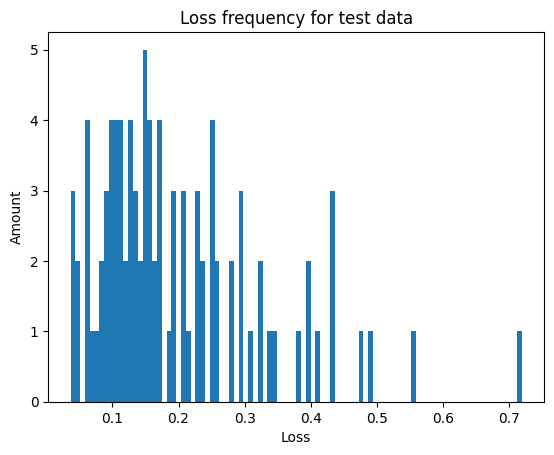

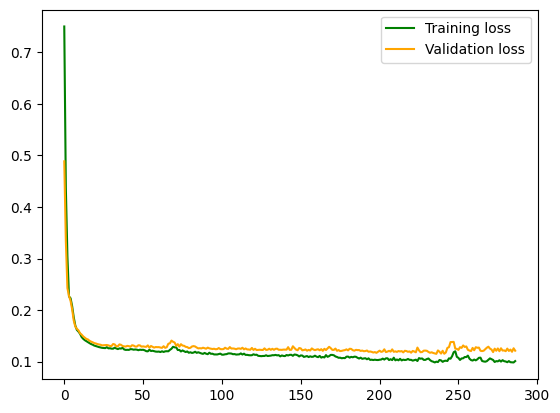

Loss average is: 0.19833700052414002
Loss mode is: [(0.08834, 1), (0.11316, 1), (0.08792, 1), (0.28001, 1), (0.48688, 1), (0.11568, 1), (0.03725, 1), (0.25749, 1), (0.10347, 1), (0.14576, 1)]
Loss median is: 0.15821000000000002
Used time: 21.194573879241943 seconds

3/3 [==============================] - 0s 3ms/step


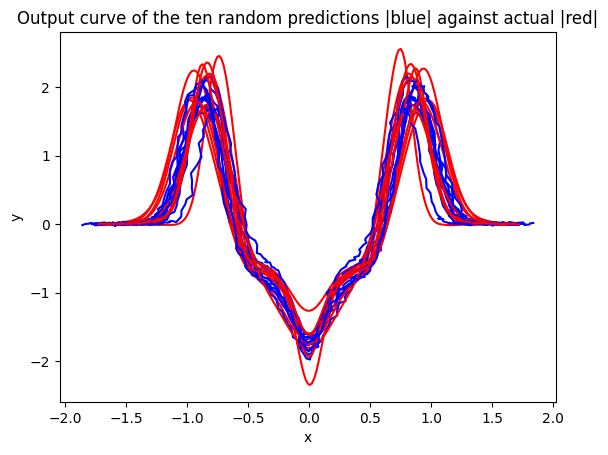

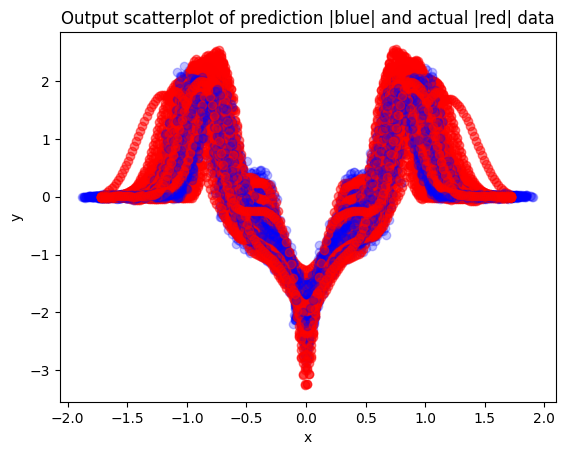

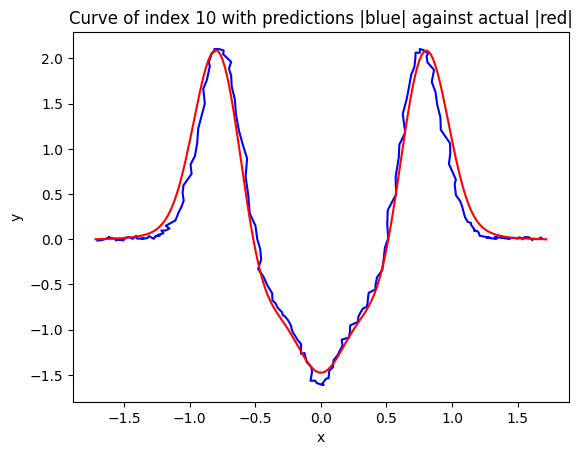

The loss of the curve 0.07701978403656588


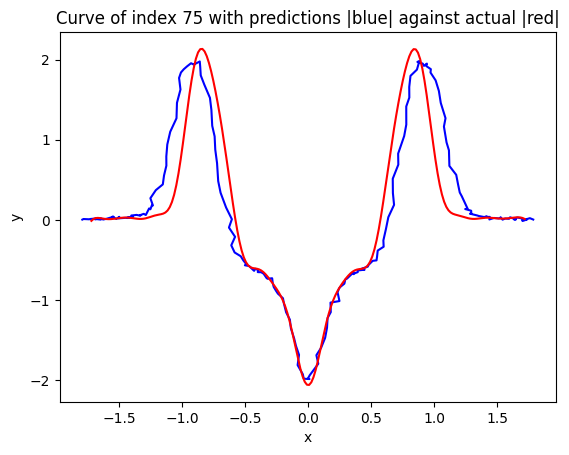

The loss of the curve 0.17132451773175997


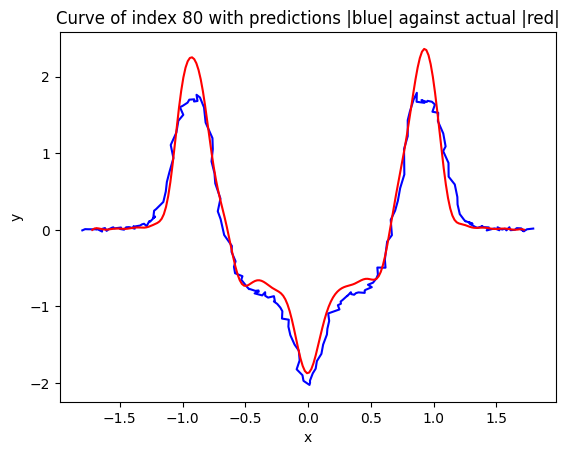

The loss of the curve 0.14949730316232399


In [36]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=50, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(train_input.shape[1],))
x = layers.Dense(1000, activation='relu')(inputs)
x = layers.Dense(1000, activation='relu')(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

3/3 [==============================] - 0s 7ms/step


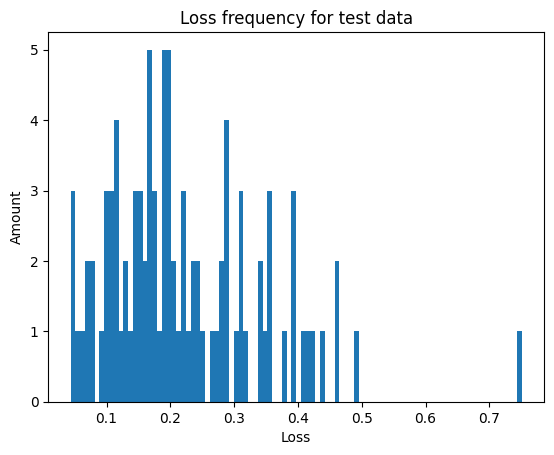

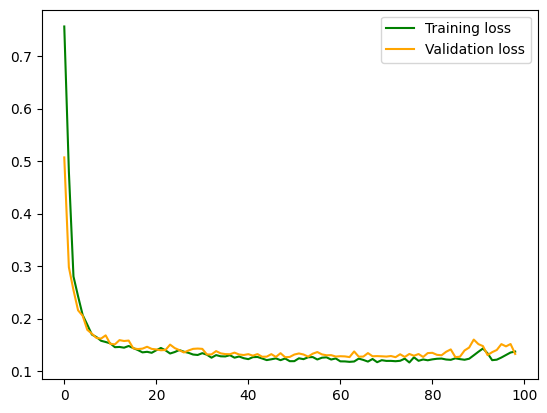

Loss average is: 0.22327200690486895
Loss mode is: [(0.11416, 1), (0.19975, 1), (0.04589, 1), (0.29011, 1), (0.44106, 1), (0.10043, 1), (0.06808, 1), (0.39176, 1), (0.09666, 1), (0.13157, 1)]
Loss median is: 0.19704
Used time: 15.434022903442383 seconds

3/3 [==============================] - 0s 7ms/step


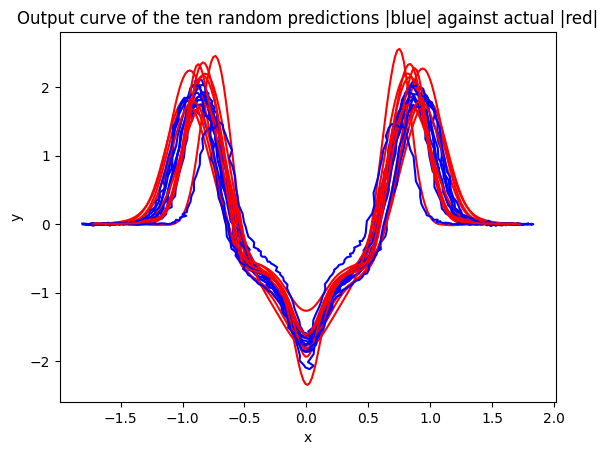

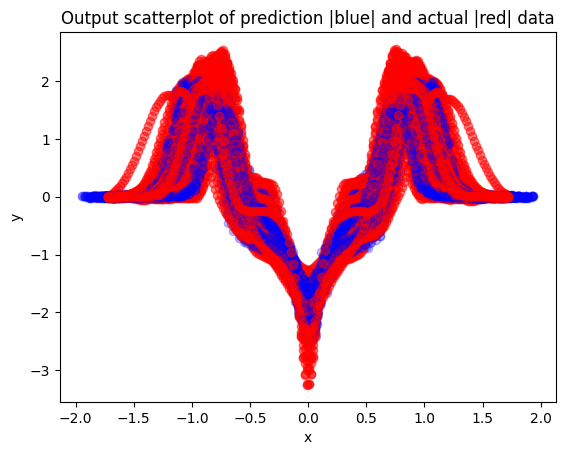

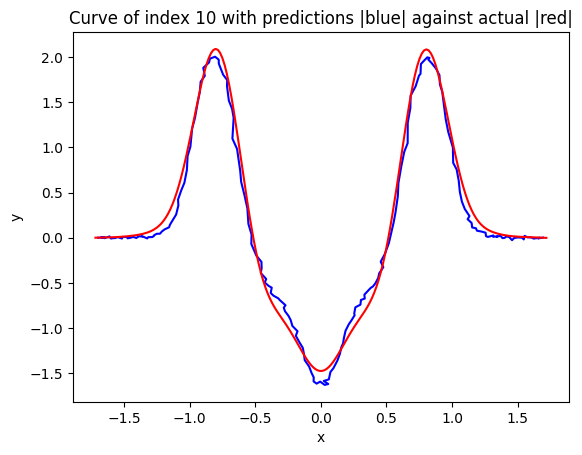

The loss of the curve 0.09808354686735259


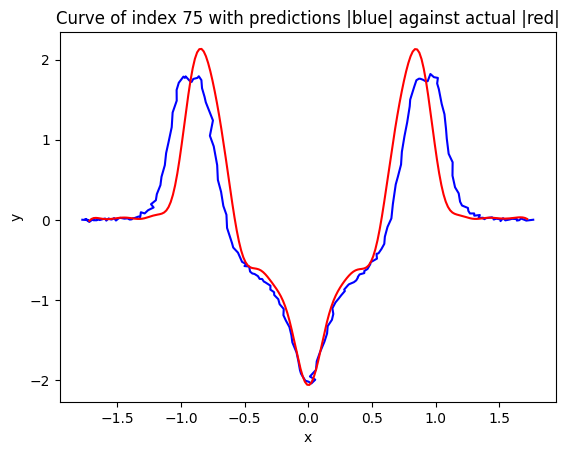

The loss of the curve 0.2008475325813722


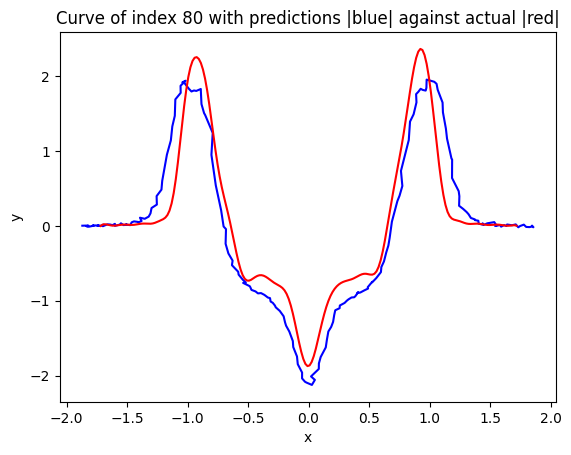

The loss of the curve 0.19159496869905204


In [37]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=50, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(train_input.shape[1],))
x = layers.Dense(1000, activation='relu')(inputs)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

3/3 [==============================] - 0s 17ms/step


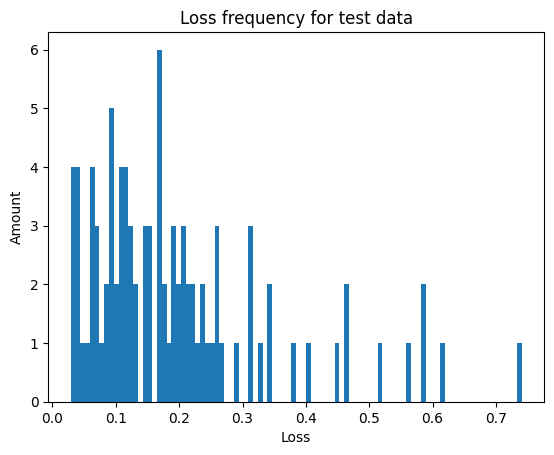

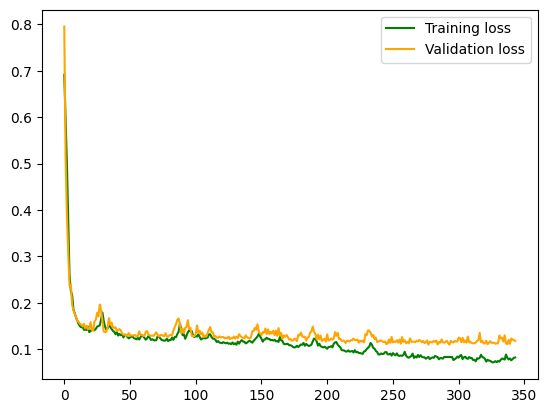

Loss average is: 0.19699577054993472
Loss mode is: [(0.07321, 1), (0.06792, 1), (0.12263, 1), (0.21578, 1), (0.61672, 1), (0.17152, 1), (0.02901, 1), (0.34384, 1), (0.19118, 1), (0.22833, 1)]
Loss median is: 0.165665
Used time: 148.83402299880981 seconds

3/3 [==============================] - 0s 17ms/step


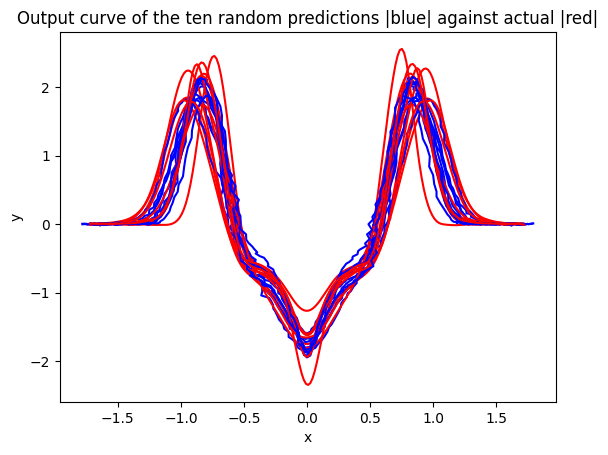

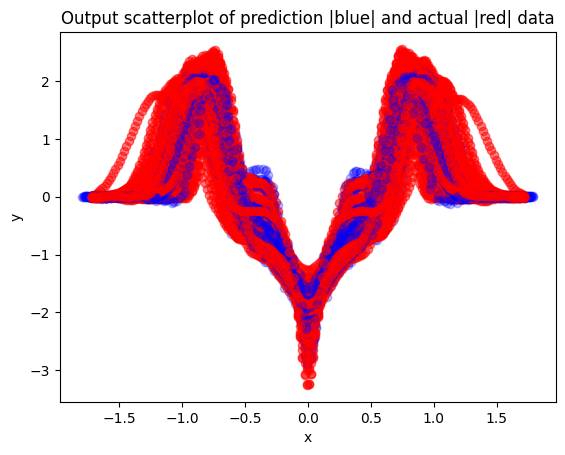

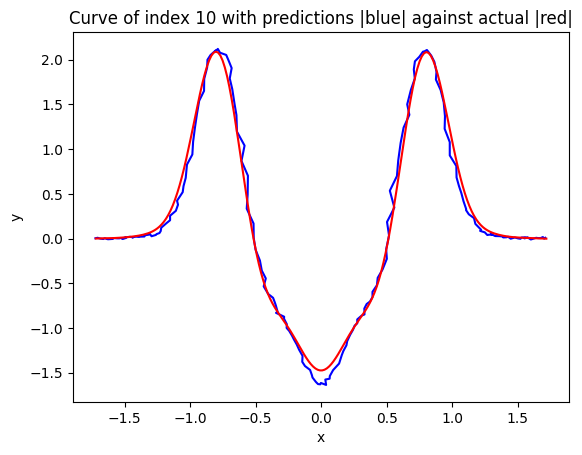

The loss of the curve 0.06443867377166188


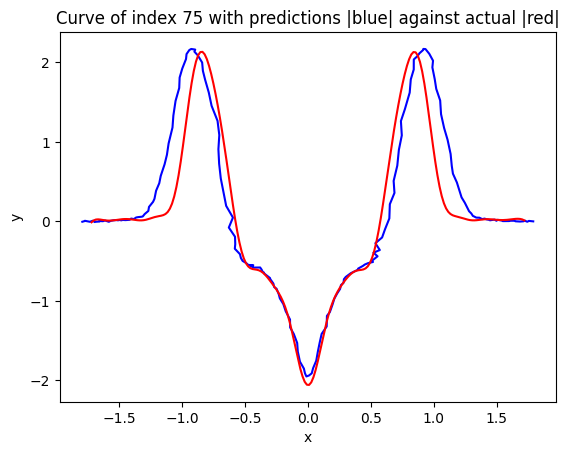

The loss of the curve 0.17951780270661732


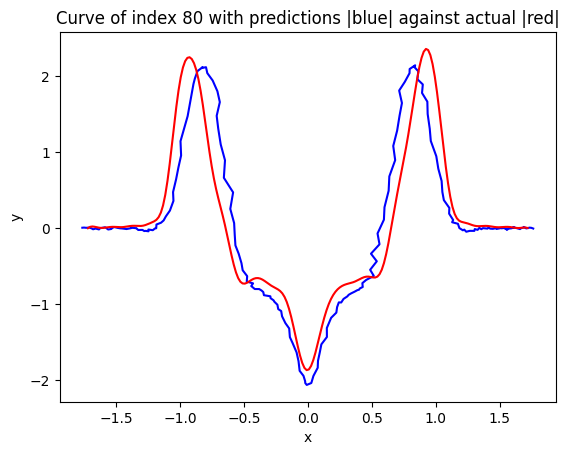

The loss of the curve 0.34664563741222243


In [38]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=50, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(train_input.shape[1],))
x = layers.Dense(2000, activation='relu')(inputs)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dense(2000, activation='relu')(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

3/3 [==============================] - 0s 19ms/step


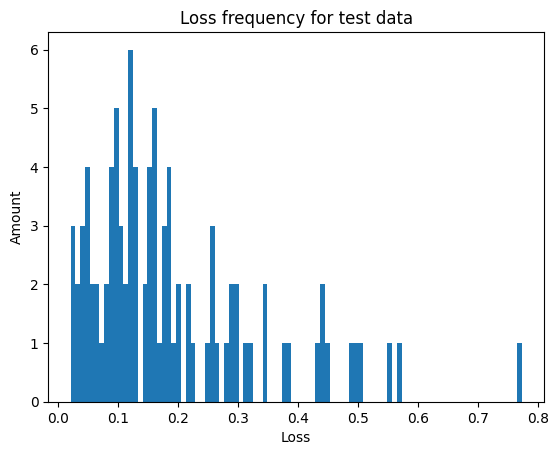

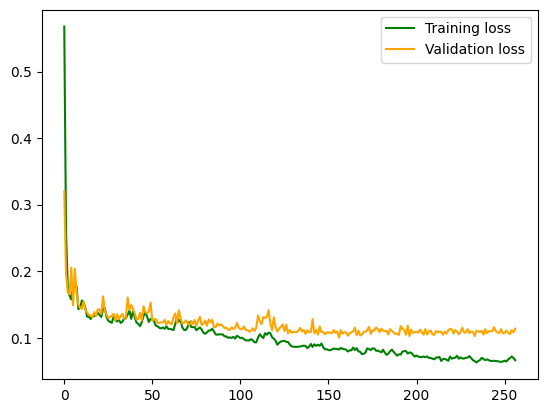

Loss average is: 0.1909656009318272
Loss mode is: [(0.03616, 1), (0.24603, 1), (0.04955, 1), (0.25805, 1), (0.57116, 1), (0.19985, 1), (0.02928, 1), (0.34562, 1), (0.16307, 1), (0.18391, 1)]
Loss median is: 0.154335
Used time: 446.0710229873657 seconds

3/3 [==============================] - 0s 18ms/step


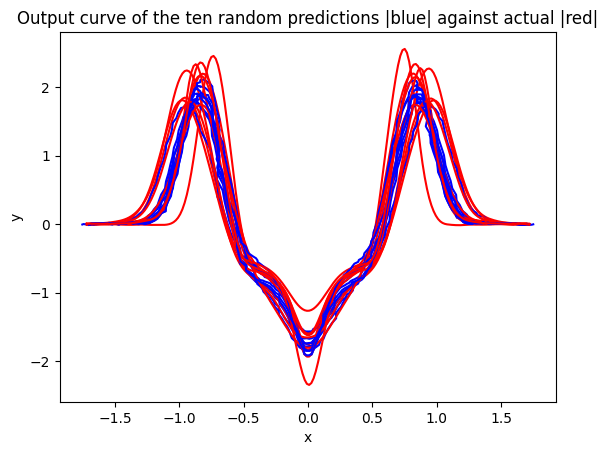

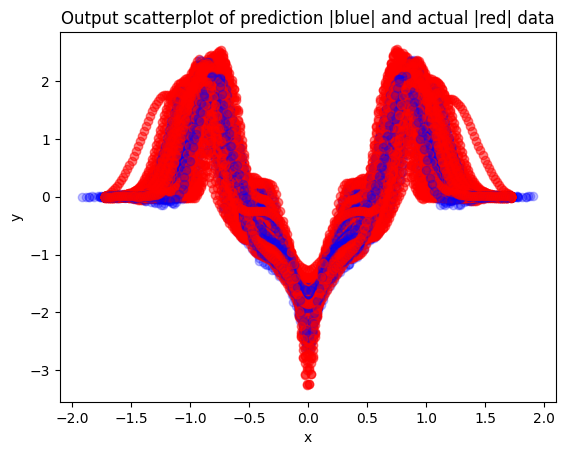

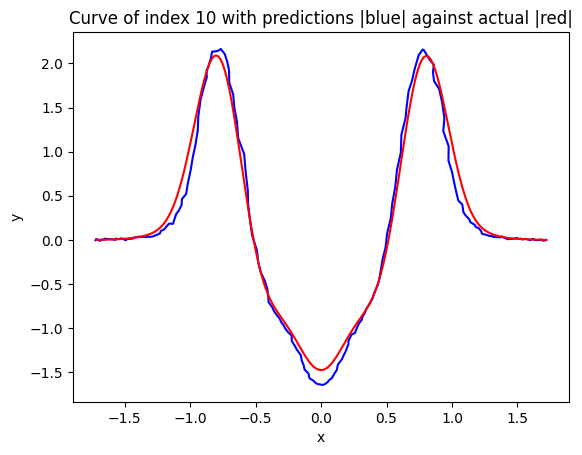

The loss of the curve 0.10994367925066356


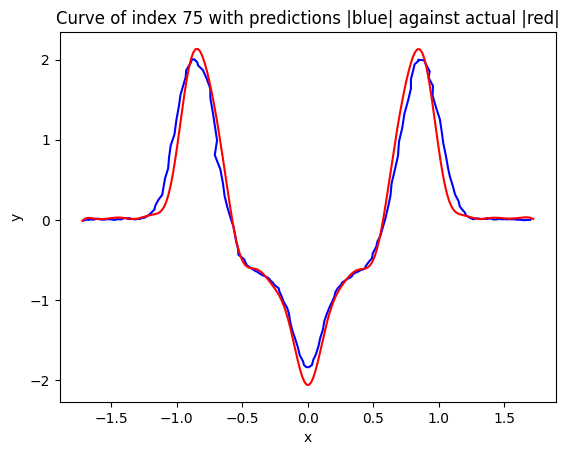

The loss of the curve 0.12213438842036356


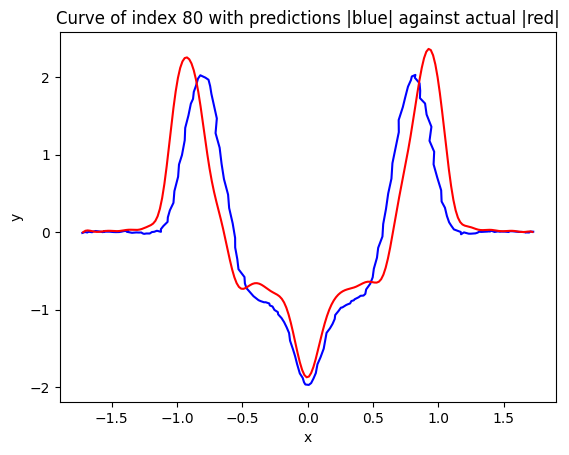

The loss of the curve 0.34623997276186935


In [39]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(train_input.shape[1],))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dense(3000, activation='relu')(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=64, epochs=800, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

3/3 [==============================] - 0s 17ms/step


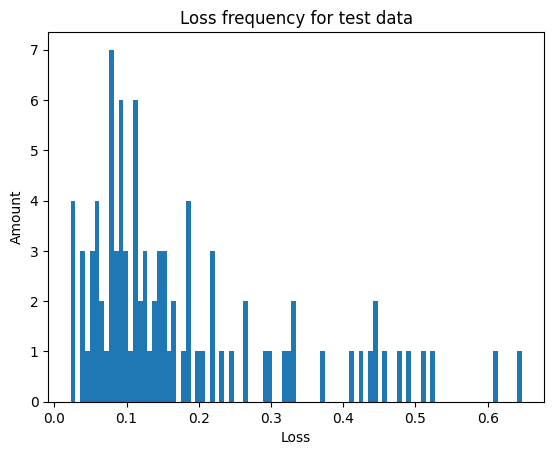

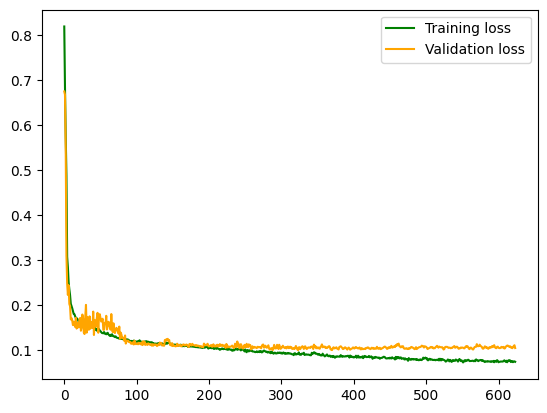

Loss average is: 0.17921345386516424
Loss mode is: [(0.08706, 1), (0.0866, 1), (0.03786, 1), (0.21804, 1), (0.61327, 1), (0.19675, 1), (0.0475, 1), (0.32911, 1), (0.07828, 1), (0.12779, 1)]
Loss median is: 0.12538
Used time: 619.270122051239 seconds

3/3 [==============================] - 0s 17ms/step


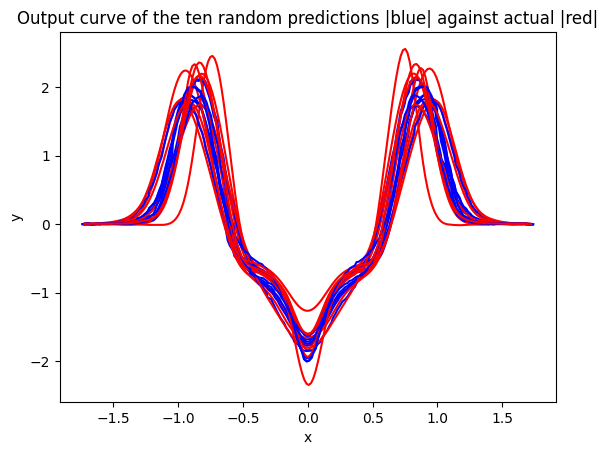

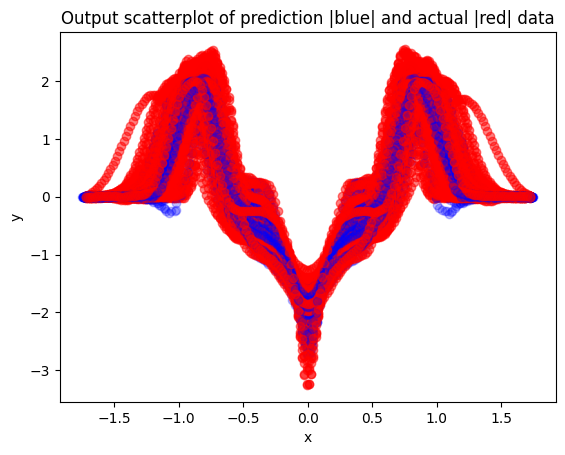

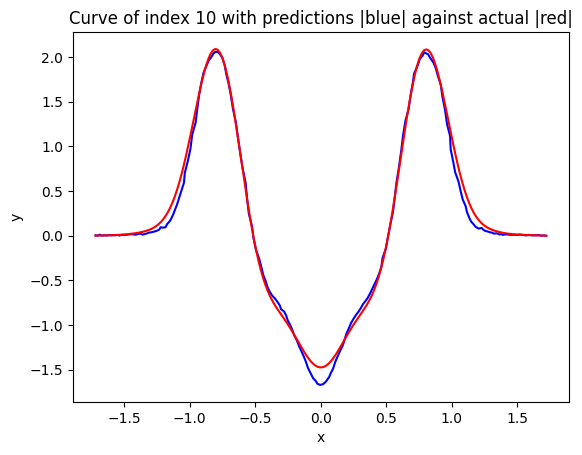

The loss of the curve 0.057078187629716615


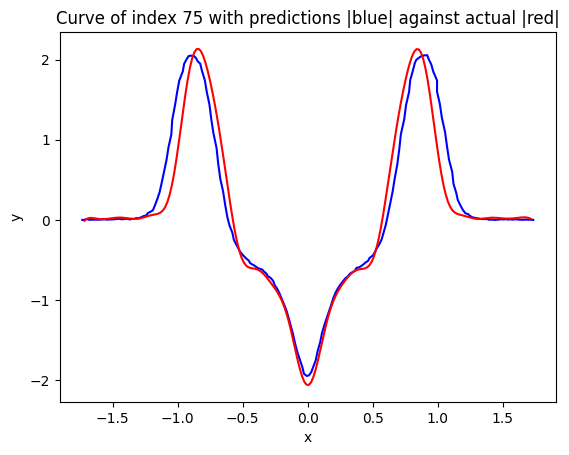

The loss of the curve 0.14778825605121138


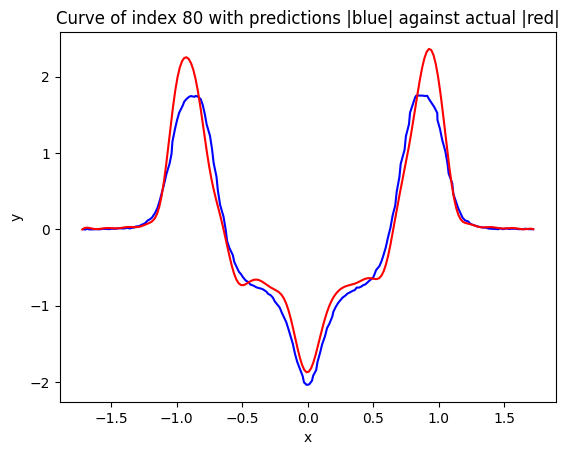

The loss of the curve 0.1498051939673037


In [6]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(train_input.shape[1],))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

In [ ]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=300, 
                       restore_best_weights=True)]

Adam = tf.keras.optimizers.Adam(amsgrad=True)

inputs = keras.Input(shape=(train_input.shape[1],))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.2, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam, loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

In [32]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=50, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1000, activation='relu')(inputs)
x = layers.Dense(1000, activation='relu')(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

ValueError: in user code:

    File "D:\Users\CellScatter\venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "D:\Users\CellScatter\venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Users\CellScatter\venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "D:\Users\CellScatter\venv\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "D:\Users\CellScatter\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Users\CellScatter\venv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 1000), found shape=(None, 4)


3/3 [==============================] - 0s 9ms/step


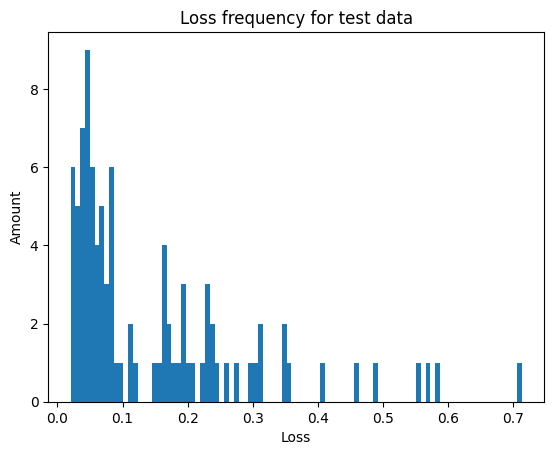

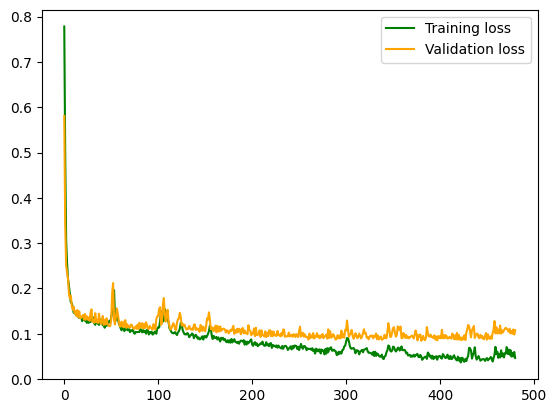

Loss average is: 0.14927835635498157
Loss mode is: [(0.03696, 1), (0.06276, 1), (0.02404, 1), (0.17291, 1), (0.16059, 1), (0.16011, 1), (0.03167, 1), (0.48776, 1), (0.22047, 1), (0.06779, 1)]
Loss median is: 0.082195
Used time: 74.23553442955017 seconds

3/3 [==============================] - 0s 9ms/step


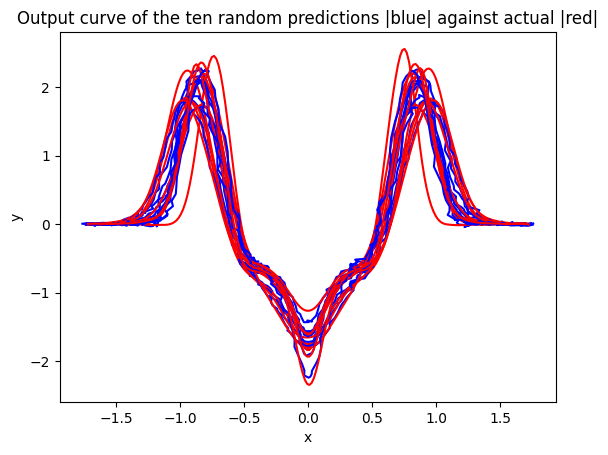

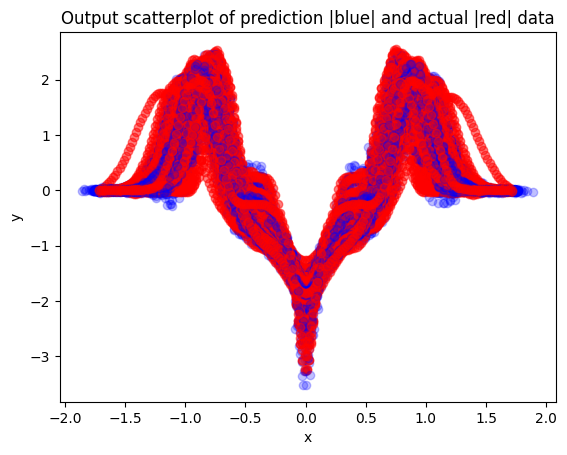

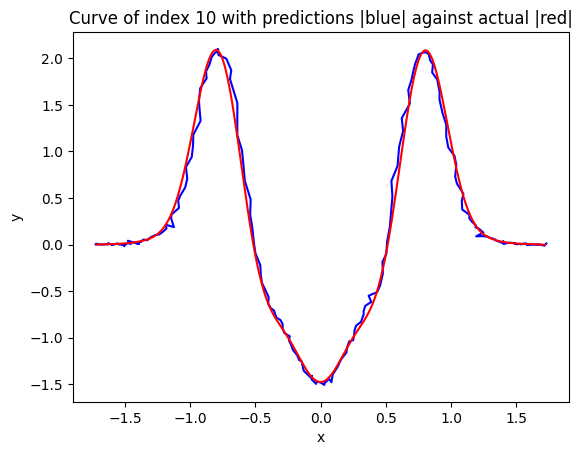

The loss of the curve 0.043621278982552025


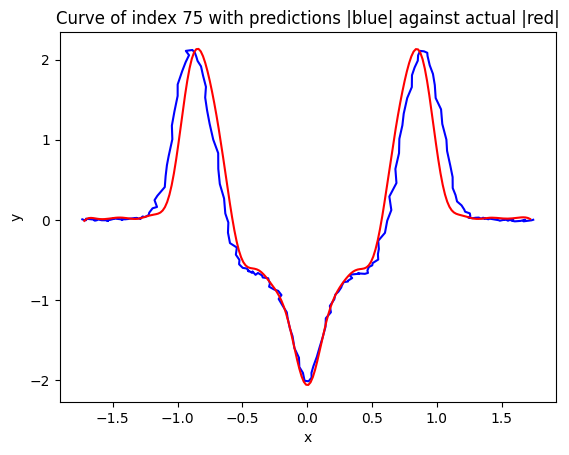

The loss of the curve 0.15238140412971302


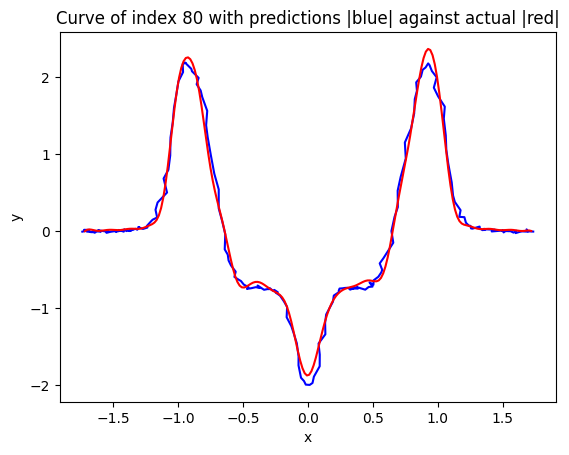

The loss of the curve 0.07509818524228543


In [110]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=100, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1000, activation='relu')(inputs)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

3/3 [==============================] - 0s 10ms/step


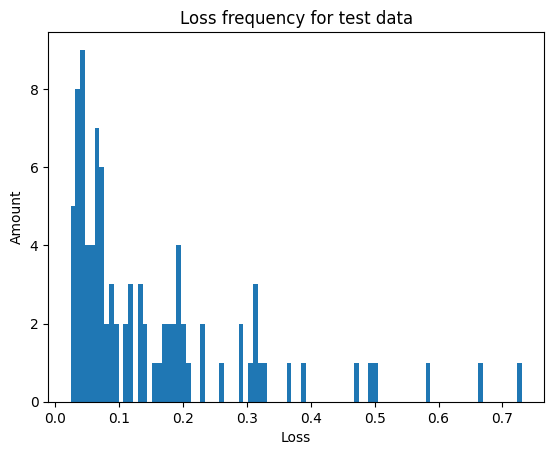

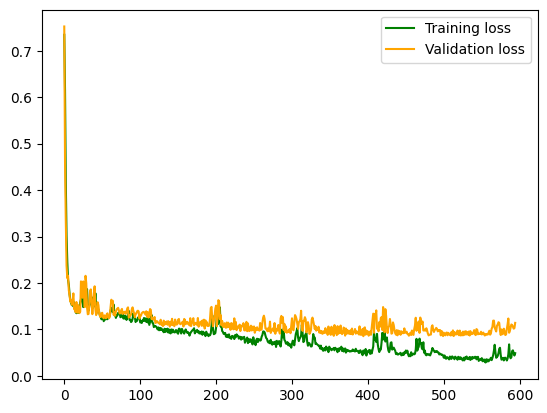

Loss average is: 0.15062836226180323
Loss mode is: [(0.07228, 1), (0.06518, 1), (0.05564, 1), (0.19532, 1), (0.12002, 1), (0.13001, 1), (0.0595, 1), (0.66382, 1), (0.19638, 1), (0.07526, 1)]
Loss median is: 0.089185
Used time: 105.34653615951538 seconds

3/3 [==============================] - 0s 10ms/step


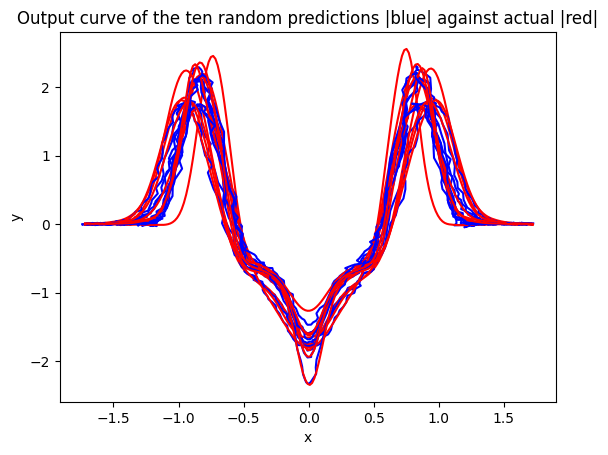

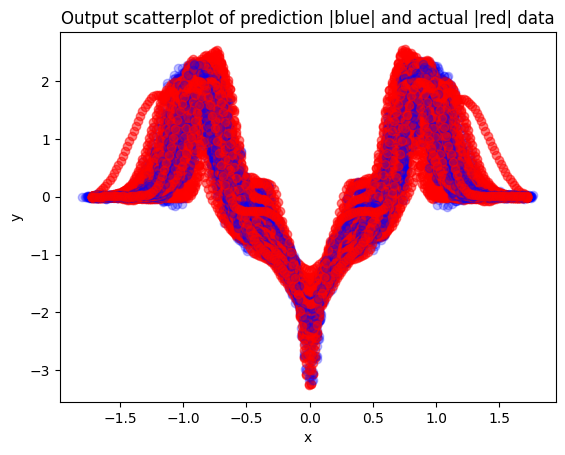

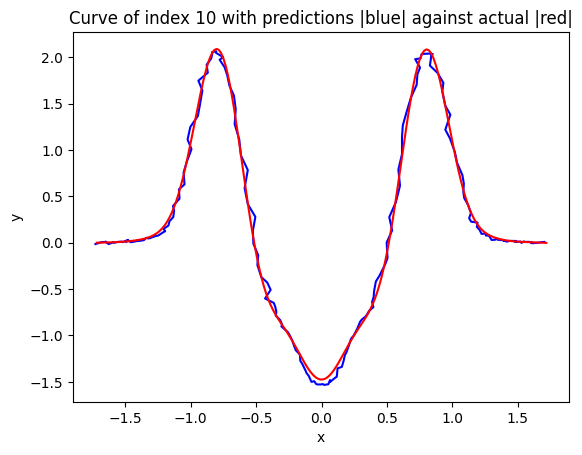

The loss of the curve 0.031052882524657016


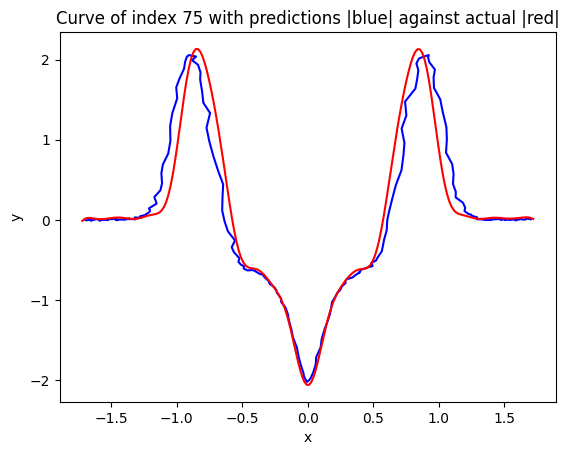

The loss of the curve 0.19898376590810116


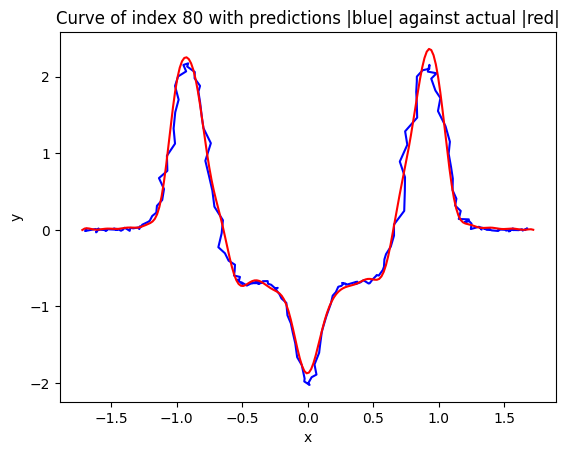

The loss of the curve 0.07470394335200523


In [111]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(1000, activation='relu')(inputs)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(1000, activation='relu')(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

3/3 [==============================] - 0s 24ms/step


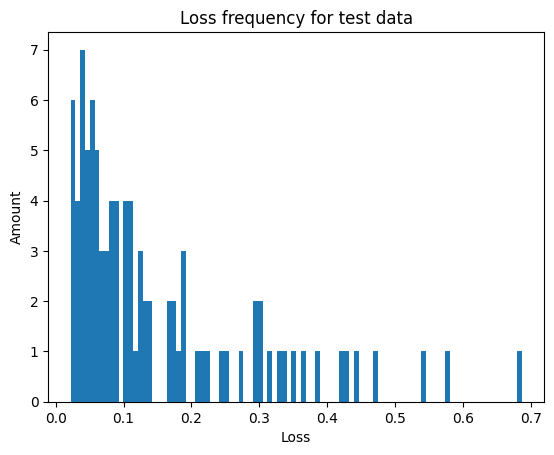

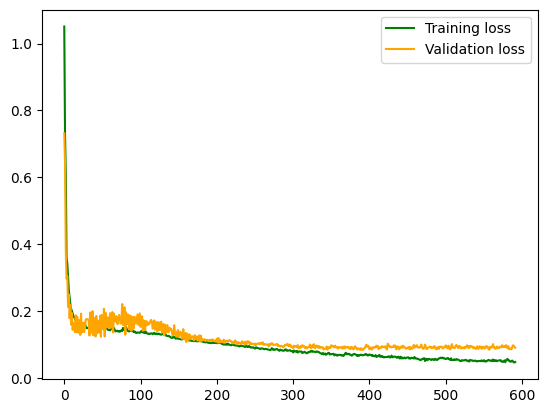

Loss average is: 0.1502112544965186
Loss mode is: [(0.04594, 1), (0.06144, 1), (0.02976, 1), (0.08192, 1), (0.07539, 1), (0.12225, 1), (0.02902, 1), (0.44085, 1), (0.1743, 1), (0.05495, 1)]
Loss median is: 0.09623999999999999
Used time: 350.5454885959625 seconds

3/3 [==============================] - 0s 23ms/step


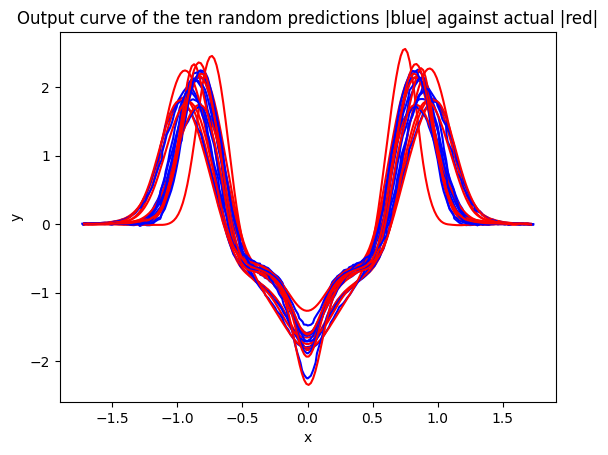

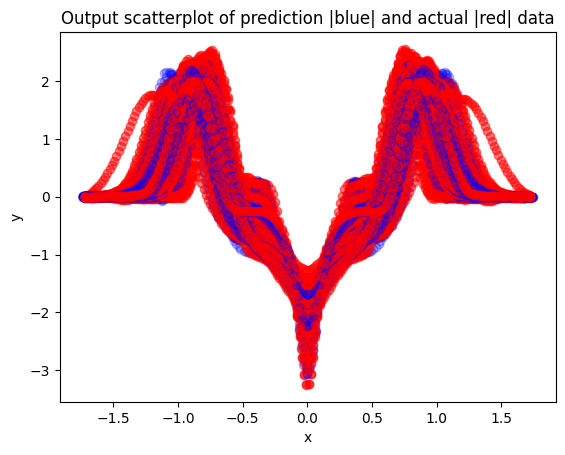

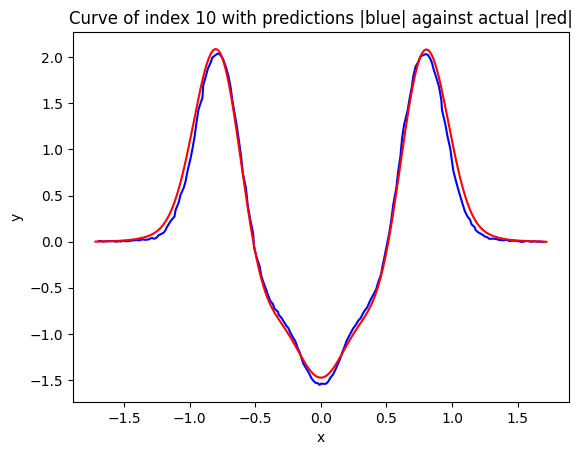

The loss of the curve 0.04426930396193371


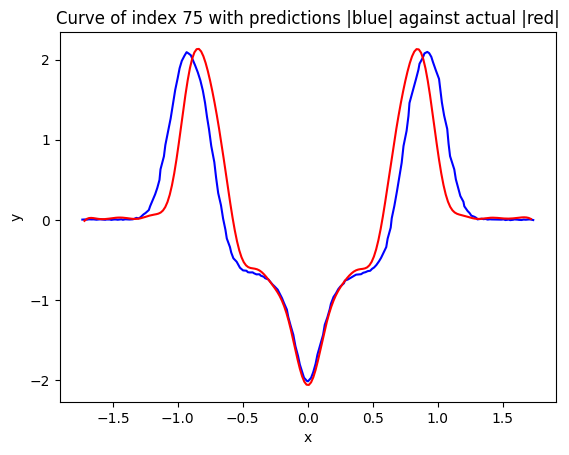

The loss of the curve 0.22671225593968208


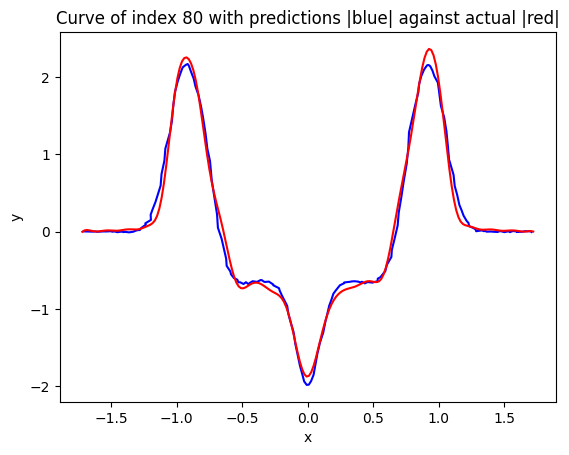

The loss of the curve 0.07646903681239582


In [112]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(2000, activation='relu')(inputs)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(2000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

3/3 [==============================] - 0s 25ms/step


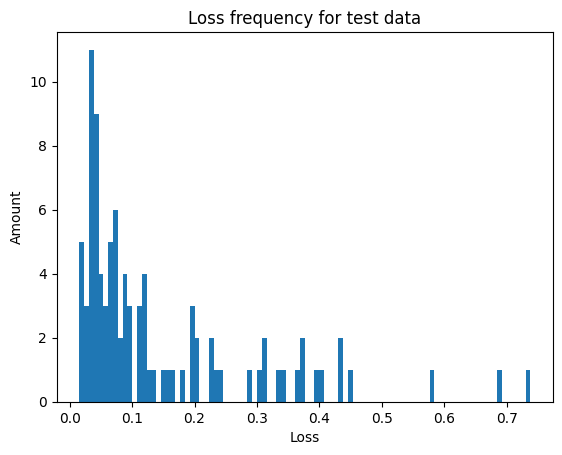

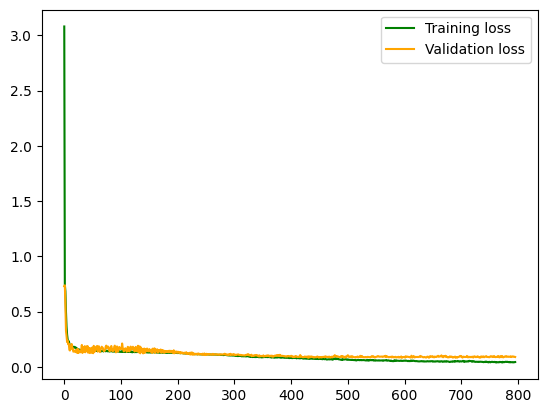

Loss average is: 0.1457933288614205
Loss mode is: [(0.06777, 1), (0.22351, 1), (0.02881, 1), (0.09188, 1), (0.07299, 1), (0.195, 1), (0.05547, 1), (0.73806, 1), (0.20572, 1), (0.09366, 1)]
Loss median is: 0.07793
Used time: 992.1609230041504 seconds

3/3 [==============================] - 0s 22ms/step


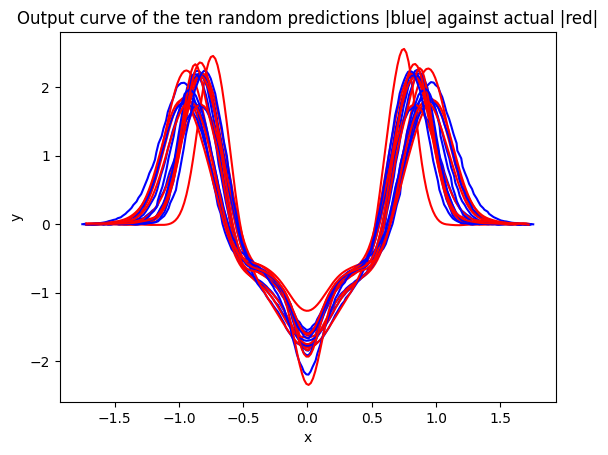

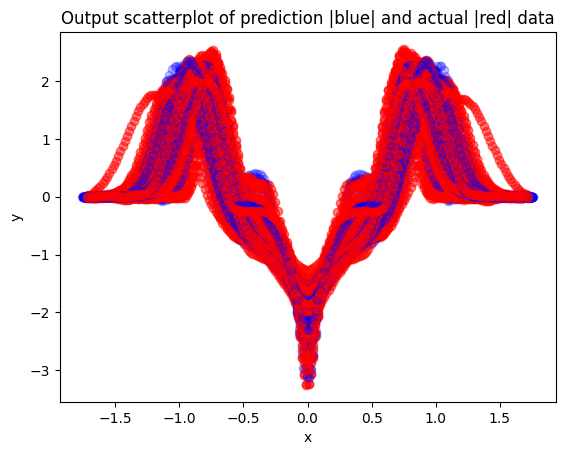

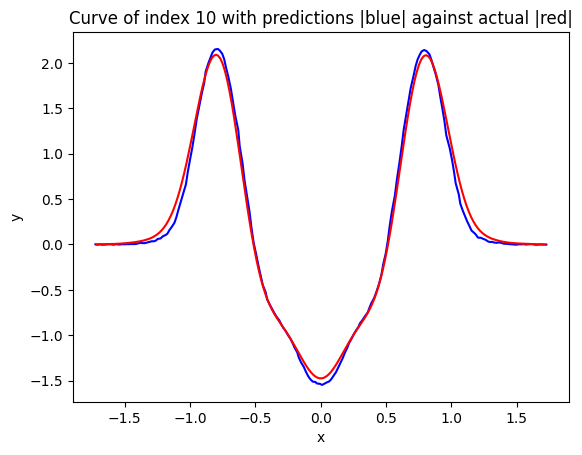

The loss of the curve 0.07360232314856377


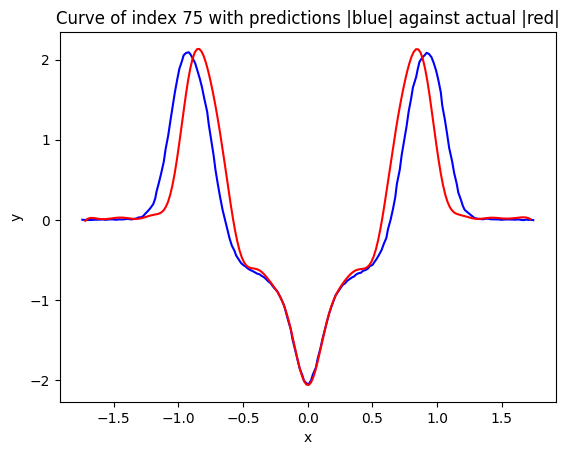

The loss of the curve 0.1985816397253432


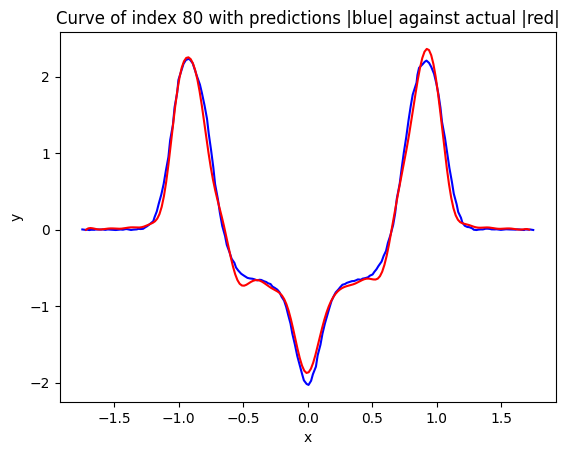

The loss of the curve 0.08829847651381265


In [113]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=158, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))

3/3 [==============================] - 0s 25ms/step


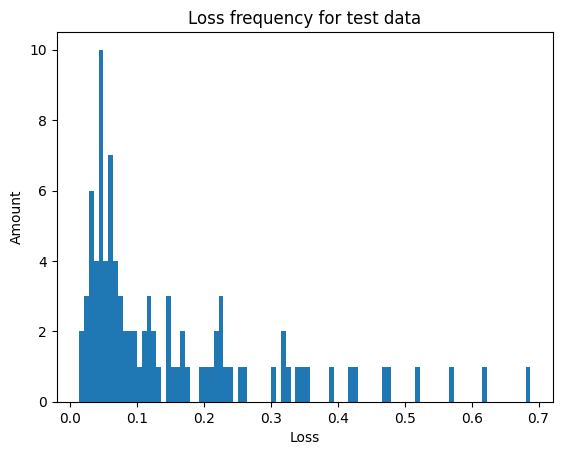

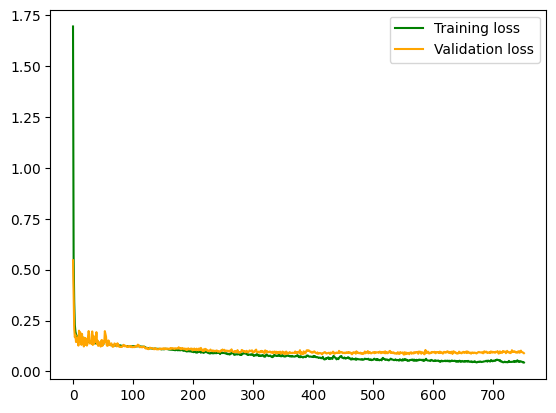

Loss average is: 0.15407349063281392
Loss mode is: [(0.03291, 1), (0.10639, 1), (0.06258, 1), (0.25447, 1), (0.0492, 1), (0.2025, 1), (0.03835, 1), (0.62324, 1), (0.19887, 1), (0.04623, 1)]
Loss median is: 0.09331
Used time: 1812.6885018348694 seconds

3/3 [==============================] - 0s 22ms/step


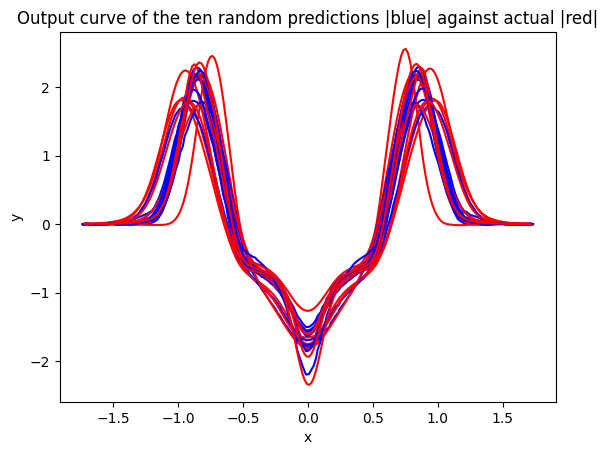

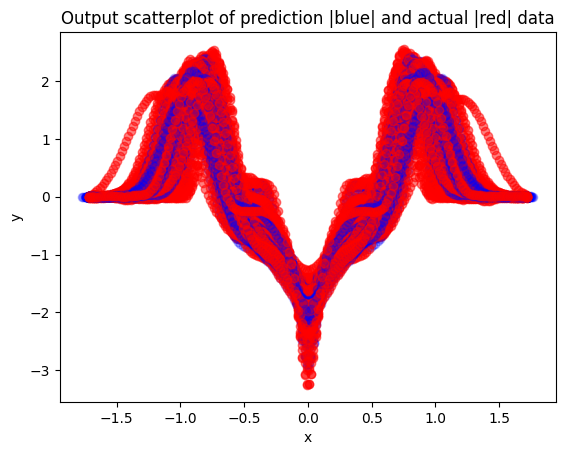

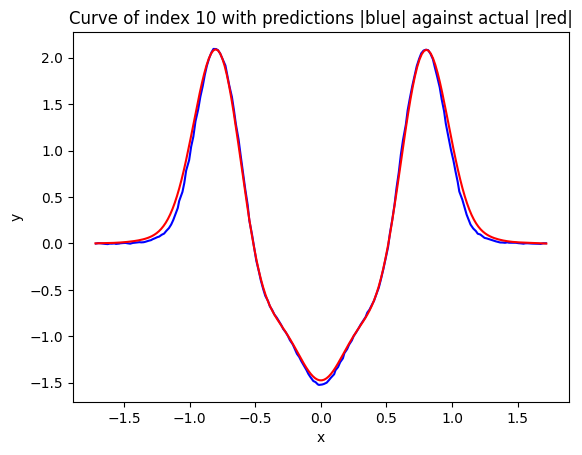

The loss of the curve 0.03352087337224521


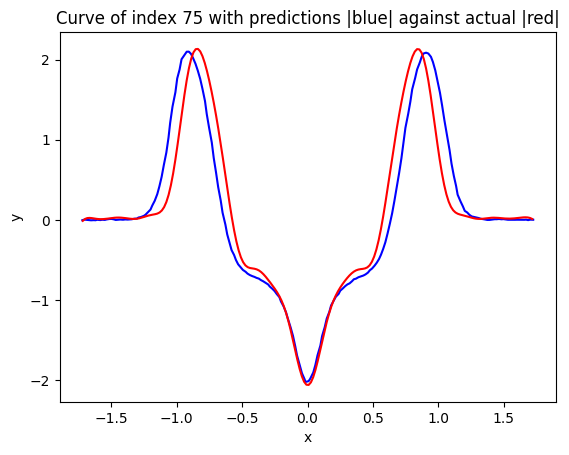

The loss of the curve 0.21152777883807578


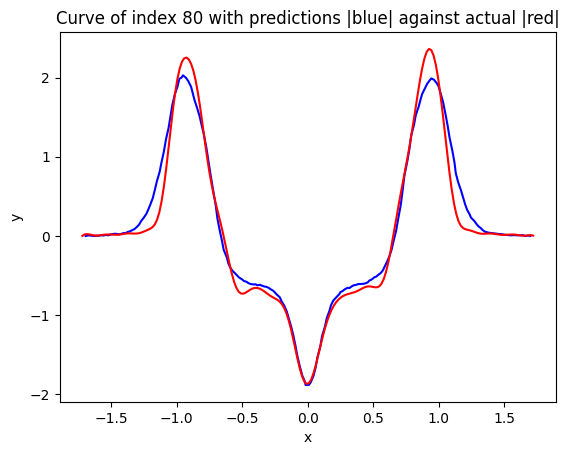

The loss of the curve 0.14789015280519233


In [114]:
general_start_time = time.time()

callbacks = [EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=200, 
                       restore_best_weights=True)]

inputs = keras.Input(shape=(1000,))
x = layers.Dense(3000, activation='relu')(inputs)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
x = layers.Dense(3000, activation='relu')(x)
x = layers.Dropout(0.1, seed=42)(x)
outputs = layers.Dense(400)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(train_input, train_output, batch_size=64, epochs=1500, validation_split=0.2, callbacks=callbacks, verbose=0)
results = metrics(test_output, model.predict(test_input))

general_end_time = time.time()

plt.plot(history.history['loss'], color = 'green', label = 'Training loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'Validation loss')
plt.legend()
plt.show()

print('Loss average is: ' + str(results[0]))
print('Loss mode is: ' + str(results[1]))
print('Loss median is: ' + str(results[2]))
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')
print('')
plots(test_output,model.predict(test_input))